In [1]:
import jax
import jax.numpy as jnp
from opgp import build_solve, build_predict_scalar, residual
from functools import partial
import matplotlib.pyplot as plt

# Wave equation in 1D

$$
\left(\frac{\partial^2}{\partial x^2} - \frac{1}{c^2}\frac{\partial^2}{\partial t^2}\right) u(x, t) = 0
$$

In [2]:
c = 1

def operator(u):
    hessian_u = jax.hessian(u)
    def op_u(xt):
        h = hessian_u(xt)
        uxx = h[0,0]
        utt = h[1,1]
        return uxx - utt / c**2
    return op_u

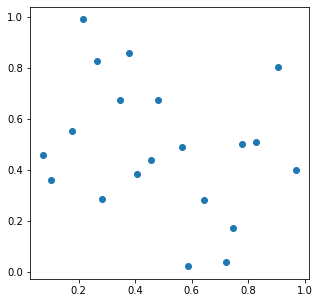

In [3]:
n_samples = 20
rng = jax.random.PRNGKey(0)
rng, key1, key2 = jax.random.split(rng, 3)
xs = jax.random.uniform(key1, (n_samples,))
ts = jax.random.uniform(key2, (n_samples,))
plt.figure(figsize=(5,5))
plt.scatter(xs, ts)

# Boundary conditions

![](https://user-images.githubusercontent.com/12683885/91465006-ecde8a80-e895-11ea-935e-2c1d60e3d1f2.png)
example from https://neuralpde.sciml.ai/dev/pinn/wave/

In [4]:
identity = lambda u: u
n1, n2, n3, n4 = 10, 10, 10, 10
boundary_x = {
    "u(0,t)": jnp.stack([jnp.zeros(n1), jnp.linspace(0,1,num=n1)]).T, 
    "u(1,t)": jnp.stack([jnp.ones(n2), jnp.linspace(0,1,num=n2)]).T,
    "u(x,0)": jnp.stack([jnp.linspace(0,1,num=n3), jnp.zeros(n3)]).T,
    "ut(x,0)": jnp.stack([jnp.linspace(0,1,num=n4), jnp.zeros(n4)]).T
}
boundary_ops = {
    "u(0,t)": identity, 
    "u(1,t)": identity,
    "u(x,0)": identity,
    "ut(x,0)": lambda u: lambda xt: -jax.grad(u)(xt)[1]
}
boundary_obs = {
    "u(0,t)": jnp.zeros(n1), 
    "u(1,t)": jnp.zeros(n2),
    "u(x,0)": boundary_x["u(x,0)"][:,0] * (1.0 - boundary_x["u(x,0)"])[:,0],
    "ut(x,0)": jnp.zeros(n4)
}

# Build model

In [5]:
def rbf(x1, x2, lengthscale=1.0):
    return jnp.exp(-0.5 * jnp.sum((x1-x2)**2) / lengthscale**2)

k = partial(rbf, lengthscale=0.2)
operators = {"wave": operator, **boundary_ops}
x = {"wave": jnp.stack([xs, ts]).T, **boundary_x}
observations = {"wave": jnp.zeros(n_samples), **boundary_obs}

solve = build_solve(k, operators)
alphas = solve(x, observations)
u_sol = build_predict_scalar(k, operators, x, alphas)

residual(u_sol, x, operators, observations)

{'u(0,t)': DeviceArray(5.97184691e-07, dtype=float64),
 'u(1,t)': DeviceArray(5.75920474e-07, dtype=float64),
 'u(x,0)': DeviceArray(2.94994054e-07, dtype=float64),
 'ut(x,0)': DeviceArray(6.05825364e-07, dtype=float64),
 'wave': DeviceArray(4.31166476e-07, dtype=float64)}

# Analytic solution

In [6]:
def u_analytic(xt):
    x, t = xt
    kterm = lambda k: 8/(k**3*jnp.pi**3) * jnp.sin(k*jnp.pi*x)*jnp.cos(c*k*jnp.pi*t)
    ks = jnp.arange(1,10001,step=2)
    return jnp.sum(jax.vmap(kterm)(ks))

residual(u_analytic, x, operators, observations)

{'u(0,t)': DeviceArray(0., dtype=float64),
 'u(1,t)': DeviceArray(2.15370749e-17, dtype=float64),
 'u(x,0)': DeviceArray(1.21101522e-13, dtype=float64),
 'ut(x,0)': DeviceArray(0., dtype=float64),
 'wave': DeviceArray(1.13567467e-16, dtype=float64)}

# Interpolated boundary baseline

In [7]:
def boundary_only():
    k = partial(rbf, lengthscale=0.2)
    solve = build_solve(k, boundary_ops)
    alphas = solve(boundary_x, boundary_obs)
    u = build_predict_scalar(k, boundary_ops, boundary_x, alphas)
    return u

u_boundary_only = boundary_only()
residual(u_boundary_only, x, operators, observations)

{'u(0,t)': DeviceArray(5.00460398e-07, dtype=float64),
 'u(1,t)': DeviceArray(4.10005176e-07, dtype=float64),
 'u(x,0)': DeviceArray(2.47005936e-07, dtype=float64),
 'ut(x,0)': DeviceArray(2.34966964e-07, dtype=float64),
 'wave': DeviceArray(1.24634601, dtype=float64)}

In [8]:
def dirichlet_only():
    k = partial(rbf, lengthscale=0.2)
    dirichlet_keys = ("u(0,t)", "u(1,t)", "u(x,0)")
    dirichlet_ops = {key: boundary_ops[key] for key in dirichlet_keys}
    dirichlet_x = {key: x[key] for key in dirichlet_keys}
    dirichlet_obs = {key: observations[key] for key in dirichlet_keys}
    solve = build_solve(k, dirichlet_ops)
    alphas = solve(dirichlet_x, dirichlet_obs)
    u = build_predict_scalar(k, dirichlet_ops, dirichlet_x, alphas)
    return u

u_dirichlet_only = dirichlet_only()
residual(u_dirichlet_only, x, operators, observations)

{'u(0,t)': DeviceArray(4.48427038e-07, dtype=float64),
 'u(1,t)': DeviceArray(2.15357608e-07, dtype=float64),
 'u(x,0)': DeviceArray(1.65057128e-07, dtype=float64),
 'ut(x,0)': DeviceArray(1.92377572e-05, dtype=float64),
 'wave': DeviceArray(1.24626752, dtype=float64)}

# Plot

In [9]:
a = jnp.linspace(0, 1, 50)
xtest = jnp.stack(jnp.meshgrid(a, a), axis=-1).reshape(-1, 2)
ux_analytic = jax.vmap(u_analytic)(xtest)
ux_sol = jax.vmap(u_sol)(xtest)
ux_boundary_only = jax.vmap(u_boundary_only)(xtest)
ux_dirichlet_only = jax.vmap(u_dirichlet_only)(xtest)

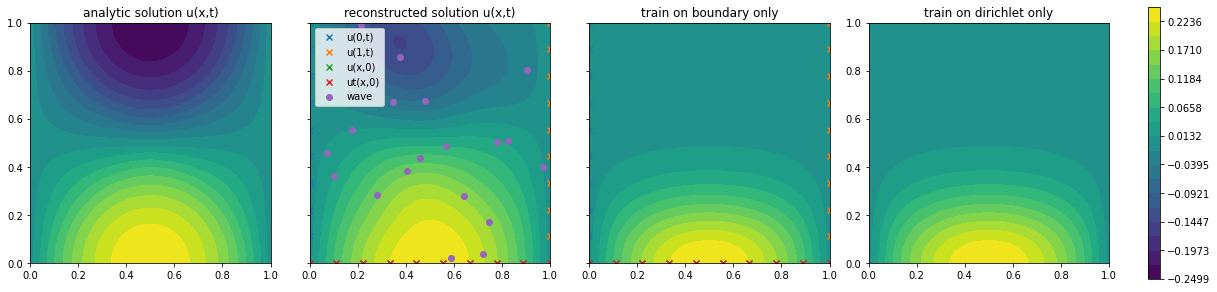

In [10]:
def plot():
    fig = plt.figure(figsize=(20.25,5))
    gs = plt.GridSpec(1,5, width_ratios=[5,5,5,5,0.25])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    ax5 = plt.subplot(gs[4])
    levels = jnp.linspace(
        min(ux.min() for ux in (ux_analytic, ux_sol, ux_boundary_only, ux_dirichlet_only)), 
        max(ux.max() for ux in (ux_analytic, ux_sol, ux_boundary_only, ux_dirichlet_only)), 
        num=20
    )
    ax1.set_title("analytic solution u(x,t)")
    c = ax1.tricontourf(*xtest.T, ux_analytic, levels=levels)
    ax1.set_aspect(1)
    
    ax2.set_title("reconstructed solution u(x,t)")
    ax2.tricontourf(*xtest.T, ux_sol, levels=levels)
    ax2.set_aspect(1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    ax3.set_title("train on boundary only")
    ax3.tricontourf(*xtest.T, ux_boundary_only, levels=levels)
    ax3.set_aspect(1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    
    markers = {"u(0,t)": 'x', "u(1,t)": 'x',"u(x,0)": 'x', "ut(x,0)": 'x'}
    for key, marker in markers.items():
        ax2.scatter(*x[key].T, label=key, marker=marker)
        ax3.scatter(*x[key].T, label=key, marker=marker)
    ax2.scatter(*x["wave"].T, label="wave", marker='o')
    ax2.legend(loc="upper left")
    
    ax4.set_title("train on dirichlet only")
    ax4.tricontourf(*xtest.T, ux_dirichlet_only, levels=levels)
    ax4.set_aspect(1)
    
    plt.colorbar(c, cax=ax5)
    plt.close()
    return fig
    
fig = plot()
fig

In [11]:
fig.savefig("wave.pdf")